In [1]:
import numpy as np
import glob
import h5py
import os
import mne
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt

#pathData     = '/Users/benjamin/DVPT/EEG/Data/AllSubjects_events_collision/'
pathData     = '/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/AllSubjects_events_collision/'
pathDataRaw     = '/Users/obando_c/Documents/Neuro/EmergencyBraking/data/raw/'

eventFiles   = glob.glob(pathData+"*_event*")
noEventFiles = glob.glob(pathData+"*_noevent*")
rawFiles   = glob.glob(pathDataRaw+"*.mat")

nEvent       = len (eventFiles)
nNoEvent     = len (noEventFiles)
nSample      = nEvent + nNoEvent
nSubjects    = len (rawFiles)
nChannels    = 59

# MNE parameters
fs = 200
tmin = -0.3  # Target segment interval intial point -> corresponds to 300ms before the event
tmax = 1.2  # Target segment interval final point -> corresponds to 1200ms after the event
nTimeStep    = int((abs(tmin) + tmax)*fs + 1)
baseline_correction = 0.1
ch_types = 'eeg'
event_id = {'braking': 0, 'collision': 1}  #
montage_std = make_standard_montage('biosemi64') # eeg montage

## <font color='blue'> Creating events epochs from raw data using MNE </font>

In [2]:
signalEvent   = np.zeros ( (nEvent  , nChannels, nTimeStep), dtype=float)
signalNoEvent = np.zeros ( (nNoEvent, nChannels, nTimeStep), dtype=float)

temp1 = 0
temp2 = 0
for i in range (nSubjects):
    with h5py.File(rawFiles  [i], 'r') as f:
        mrk = f.get('mrk')
        time_mrk = np.array(mrk.get('time'))  # mrk.time is the timestamp for each event in milliseconds
        y = np.array(mrk.get('y')) 
        
        ###### Events
        car_brake = time_mrk.T * y[:, 1]  # contains the time in ms of events car_brake
        car_collision = time_mrk.T * y[:, 3]

        events = np.array(car_brake[car_brake > 0] / 5).astype(int)
        
        ### Collision Events
        # Find events with collision when comparing car_brake, car_collision, no need to convert with /5
        car_brake_y = car_brake[car_brake > 0]
        car_collision_y = car_collision[car_collision > 0]
        
        collison_label    = []
        for j in range(len(car_brake_y)):
            diff = car_collision_y - car_brake_y[j]
            if (len(diff[diff > 0]) == 0):
                collison_label.append(0)
            elif (min(diff[diff > 0]) > 25000):  # car_brake_y[i] is too far from any collision, so label = 0, 25000 is
                collison_label.append(0)
            else:
                collison_label.append(1)
        ##### Matrix of events anotations
        events_collison = np.empty([len(events), 3], dtype=int)
        events_collison[:, 0] = events
        events_collison[:, 1] = int(0)
        events_collison[:, 2] = np.array(collison_label).astype(int)
        
        cnt = f.get('cnt')
        x = np.array(cnt.get('x'))
        test = f['cnt/clab']
        name_elec = list()
        for j in range(len(test)):
            st = test[j][0]
            obj = f[st]
            str1 = ''.join(chr(i) for i in obj[:])
            name_elec.append(str1)
        channels_eeg = np.delete(np.arange(61), [0, 5])
        
        ###### EEG data in MNE
        ch_names = np.array(name_elec)[channels_eeg]
        eeg_data = x[channels_eeg, :]
        info = mne.create_info(ch_names=ch_names.tolist(), sfreq=fs, ch_types=ch_types)  # , ch_types = ch_types)
        info.set_montage(montage_std)
        raw = mne.io.RawArray(eeg_data, info)

        # ###### Filter Data
        # raw = raw.copy()
        # raw.filter(filter_0, filter_1, fir_design='firwin')

        ##### Picks
        picks = mne.pick_types (raw.info, meg=False, eeg=True, eog=False,
                                exclude='bads')

        ##### Epochs
        epochs = mne.Epochs(raw, events_collison, event_id, tmin=tmin, tmax=tmax, proj=True,
                            picks=picks, baseline=(None, baseline_correction), preload=True,
                            reject=None)

        
        signalEvent[temp1:temp1+epochs['collision']._data.shape[0]] = epochs['collision']._data
        signalNoEvent[temp2:temp2+epochs['braking']._data.shape[0]] = epochs['braking']._data
        
        temp1 += epochs['collision']._data.shape[0]
        temp2 += epochs['braking']._data.shape[0]


Creating RawArray with float64 data, n_channels=59, n_times=1619967
    Range : 0 ... 1619966 =      0.000 ...  8099.830 secs
Ready.
Not setting metadata
Not setting metadata
237 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 237 events and 301 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=59, n_times=1619944
    Range : 0 ... 1619943 =      0.000 ...  8099.715 secs
Ready.
Not setting metadata
Not setting metadata
226 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 226 events and 301 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=59, n_times=1619949
    Range : 0 ... 1619948 =      0.000 ...  8099.740 secs
Ready.
Not setting metadata
Not setting metadata
206 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 206

In [3]:
signals  = np.concatenate((signalEvent, signalNoEvent))
mu       = np.mean (signals, axis=0)
signalsC = signals - mu

mu1  = np.mean (signalEvent  , axis=0)
mu2  = np.mean (signalNoEvent, axis=0)

* Creation du maillage Saptio-temporel

In [4]:
#file_name ='/Users/benjamin/DVPT/EEG/Data/VPja.mat'
file_name ='/Users/obando_c/Documents/Neuro/EmergencyBraking/data/raw/VPja.mat'
with h5py.File(file_name, 'r') as f:
    mnt = f.get('mnt')
    pos3d_allChannels = np.array(mnt.get('pos_3d')) 

pos3d_eegChannels = pos3d_allChannels[np.delete(np.arange(61), [0, 5])]

spatiotemp_mesh = []
for p in pos3d_eegChannels[:nChannels]: 
    xi, yi, zi = tuple(p)
    for ti in range(nTimeStep):
        spatiotemp_mesh.append([xi, yi, zi, ti])

* KL decomposition sur tous les Signaux 

In [5]:
# import openturns as ot
# dim_ch_in  = 1 
# dim_ch_out = 1 
# process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
# for k in range(process_sample.getSize()):
#     process_sample[k] = signalsC[k].reshape(-1,1) # This doesn't work with my version of openturns
# 
# s    = 0.0 
# w_v  = np.ones(nChannels*nTimeStep) 
# algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) 
# algo.run()

# fPCA     = algo.getResult()

import openturns as ot
dim_ch_in  = 1 
dim_ch_out = 1 
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) 
for k in range(process_sample.getSize()):
    field.setValues(signalsC[k].reshape(-1,1))
    process_sample[k] = field

s    = 0.0 
w_v  = np.ones(nChannels*nTimeStep) 
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) 
algo.run()

fPCA     = algo.getResult()

## Create a video for mode 0

In [17]:
modes   = fPCA.getModes()
mode_indx = 1
mode_0 = np.array(modes[mode_indx](spatiotemp_mesh)).reshape(59,301)
mode_0 = (mode_0 - mode_0.mean(axis=0).reshape(1, 301)) / mode_0.std(axis=0).reshape(1, 301)


x_pos = pos3d_eegChannels[:,0]
y_pos = pos3d_eegChannels[:,1]

from scipy.interpolate import griddata
xi = np.linspace(-2,6,300);
yi = np.linspace(-2,6,300);

vmin_mode = 100
vmax_mode = -1
for i in range(mode_0.shape[1]):
    zi = griddata((x_pos, y_pos), mode_0[:,i], (xi[None,:], yi[:,None]), method='cubic')
    vmin_mode = min(vmin_mode, min(np.array(zi)[~np.isnan(np.array(zi))]))
    vmax_mode = max(vmax_mode , max(np.array(zi)[~np.isnan(np.array(zi))]))
min_clim = min(np.array(mode_0).flatten())
max_clim = max(np.array(mode_0).flatten())

In [18]:
print(vmin_mode,vmax_mode)
print(min_clim,max_clim)

-3.310826558462911 7.071058227305351
-3.0356249374045383 6.255181253141088


(-1.1, 1.1, -1.1, 1.0788638084435536)

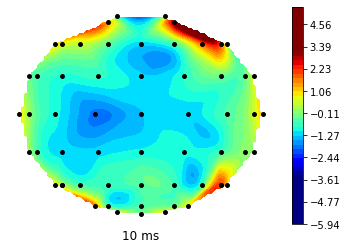

In [13]:
tp = 2
zi = griddata((x_pos, y_pos), mode_0[:,tp], (xi[None,:], yi[:,None]), method='cubic')
levels = [-1.5, -1, -0.5, 0, 0.5, 1]
levels = np.linspace(vmin_mode,vmax_mode,50);
plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=vmin_mode, vmax=vmax_mode,levels = levels)
plt.colorbar(extend='both')
plt.clim(min_clim*0.9, max_clim*0.9)

plt.scatter(x_pos,y_pos,marker='o',c='k',s=15)

plt.xlim(min(x_pos)*1.1,max(x_pos)*1.1)
plt.ylim(min(y_pos)*1.1,max(y_pos)*1.1)
plt.title(str(tp*5) + ' ms', y=-0.1)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left = False,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft = False) # labels along the bottom edge are off
plt.axis('off')
#plt.savefig('/Users/obando_c/Documents/Neuro/EmergencyBraking/notebooks/Plots/map_mode1/t'+"{0:0=3d}".format(tp)+'.png',
#            format='png',
#            dpi=100,
#            bbox_inches='tight')

In [353]:
for tp in range(mode_0.shape[1]):
    zi = griddata((x_pos, y_pos), mode_0[:,tp], (xi[None,:], yi[:,None]), method='cubic')
    levels = np.linspace(vmin_mode,vmax_mode,50);
    plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=vmin_mode, vmax=vmax_mode,levels = levels)
    plt.colorbar(extend='both')
    plt.clim(min_clim*0.5, max_clim*0.5)
    plt.scatter(x_pos,y_pos,marker='o',c='k',s=15)

    plt.xlim(min(x_pos)*1.1,max(x_pos)*1.1)
    plt.ylim(min(y_pos)*1.1,max(y_pos)*1.1)
    
    plt.title(str(tp*5) + ' ms', y=-0.1)

    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left = False,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft = False) # labels along the bottom edge are off
    plt.axis('off')
    plt.savefig('/Users/obando_c/Documents/Neuro/EmergencyBraking/notebooks/Plots/map_mode'+str(mode_indx)+'/t'+"{0:0=3d}".format(tp)+'.png',
                format='png',
                dpi=100,
                bbox_inches='tight')
    plt.close()

In [19]:
from PIL import Image
import glob
 
# Create the frames
frames = []
pathimgs = '/Users/obando_c/Documents/Neuro/EmergencyBraking/notebooks/Plots/map_mode'+str(mode_indx)+'/'
imgs = glob.glob(pathimgs+"*.png")
imgs = np.sort(imgs)
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save(pathimgs+ 'mode' + str(mode_indx)+ '_to_gif_faster.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=80, loop=0)

In [ ]:
#for tp in range(mode_0.shape[1]):
#    fig, ax = plt.subplots()
#    zi = griddata((x_pos, y_pos), mode_0[:,tp], (xi[None,:], yi[:,None]), method='cubic')
#
#    cax = ax.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=vmin_mode, vmax=vmax_mode)
#    ax.scatter(x_pos,y_pos,marker='o',c='k',s=10)
#    #ax.set_title('Gaussian noise with vertical colorbar')
#    ax.set_xlim(min(x_pos)*1.1,max(x_pos)*1.1)
#    ax.set_ylim(min(y_pos)*1.1,max(y_pos)*1.1)
#
#    # Add colorbar, make sure to specify tick locations to match desired ticklabels
#    cbar = fig.colorbar(cax, ticks=[-6,-5,-4,-3,-2,-1, 0, 1,2,3,4,5,6])
#    cbar.ax.set_yticklabels(['-6','-5','-4','-3','-2','-1', '0', '1','2','3','4','5','6'])  # vertically oriented colorbar
#    plt.savefig('/Users/obando_c/Documents/Neuro/EmergencyBraking/notebooks/Plots/map_mode0/t'+str(tp)+'.png',
#                format='png',
#                dpi=100,
#                bbox_inches='tight')
#    plt.close()

In [174]:
np.min(np.array(zi)[~np.isnan(np.array(zi))])

-2.085616134943496

In [166]:
np.max(zi[isnana])

nan

(-1.0, 0.9807852804032304)

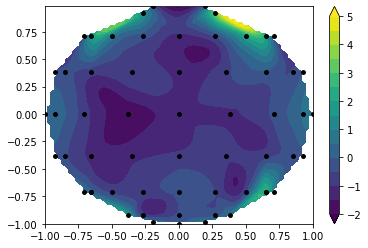

In [164]:
i = 5
zi = griddata((x_pos, y_pos), mode_0[:,i], (xi[None,:], yi[:,None]), method='cubic')
#CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
CS = plt.contourf(xi,yi,zi,15, extend='both') #,cmap=plt.cm.jet
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='k',s=15)

plt.xlim(min(x_pos),max(x_pos))
plt.ylim(min(y_pos),max(y_pos))

In [ ]:
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')

In [113]:
np.array(np.where(np.isnan(zi))).shape

(2, 85739)

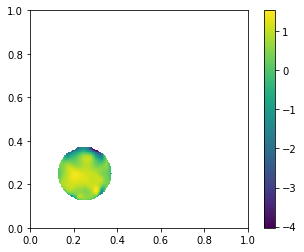

In [198]:
i = 100
zi = griddata((x_pos, y_pos), mode_0[:,i], (xi[None,:], yi[:,None]), method='cubic')
plt.imshow(zi, origin='lower', extent=(0,1,0,1))
#plt.plot(x_pos, y_pos, 'k.', ms=1)
#plt.clim(0, 10)

plt.colorbar()

In [156]:
x_pos

array([-0.19509032,  0.19509032, -0.27059805,  0.27059805, -0.70710678,
       -0.65328148, -0.5       , -0.27059805,  0.        ,  0.27059805,
        0.5       ,  0.65328148,  0.70710678, -0.92387953, -0.85355339,
       -0.65328148, -0.35355339,  0.        ,  0.35355339,  0.65328148,
        0.85355339,  0.92387953, -1.        , -0.92387953, -0.70710678,
       -0.38268343,  0.        ,  0.38268343,  0.70710678,  0.92387953,
        1.        , -0.92387953, -0.85355339, -0.65328148, -0.35355339,
        0.        ,  0.35355339,  0.65328148,  0.85355339,  0.92387953,
       -0.65328148, -0.70710678, -0.65328148, -0.5       , -0.27059805,
        0.        ,  0.27059805,  0.5       ,  0.65328148,  0.70710678,
        0.65328148, -0.38268343, -0.27059805,  0.        ,  0.27059805,
        0.38268343, -0.19509032,  0.        ,  0.19509032])

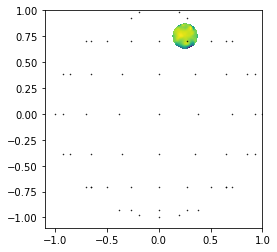

In [160]:
i = 100
zi = griddata((x_pos, y_pos), mode_0[:,i], (xi[None,:], yi[:,None]), method='cubic')
plt.imshow(zi, extent=(0,1,0,1))

plt.plot(x_pos, y_pos, 'k.', ms=1)
#plt.xlim(25,120)
#plt.ylim(30,120)
#plt.colorbar()

[Text(1, 0, '-3'),
 Text(1, 0, '-2'),
 Text(1, 0, '-1'),
 Text(1, 0, '0'),
 Text(1, 0, '1'),
 Text(1, 0, '2'),
 Text(1, 0, '3'),
 Text(1, 0, '4')]

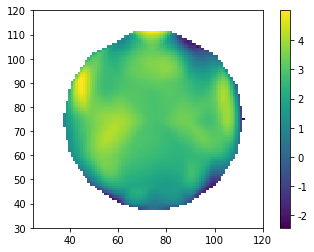

In [144]:
i=50
fig, ax = plt.subplots()
zi = griddata((x_pos, y_pos), mode_0[:,i], (xi[None,:], yi[:,None]), method='cubic')

plt.imshow(zi)
plt.xlim(25,120)
plt.ylim(30,120)
#ax.set_xlim(min(x_pos)*1.1,max(x_pos)*1.1)
#ax.set_ylim(min(y_pos)*1.1,max(y_pos)*1.1)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[-3,-2,-1, 0, 1,2,3,4])
cbar.ax.set_yticklabels(['-3','-2','-1', '0', '1','2','3','4'])  # vertically oriented colorbar

In [200]:
vmin_mode

-5.941498917861729

(-1.1, 1.0788638084435536)

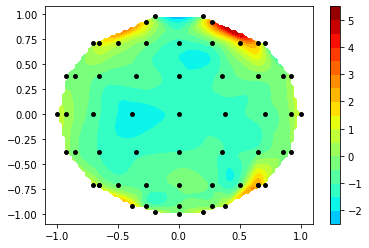

In [213]:
i = 1
zi = griddata((x_pos, y_pos), mode_0[:,i], (xi[None,:], yi[:,None]), method='cubic')
#CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=vmin_mode, vmax=vmax_mode)
plt.clim(vmin_mode, vmax_mode)
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='k',s=15)

plt.xlim(min(x_pos)*1.1,max(x_pos)*1.1)
plt.ylim(min(y_pos)*1.1,max(y_pos)*1.1)

(-1.1, 1.0788638084435536)

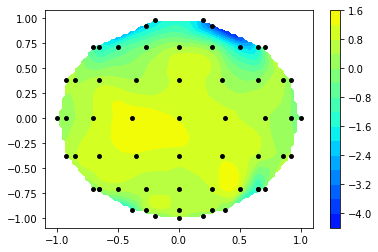

In [208]:
i = 100
zi = griddata((x_pos, y_pos), mode_0[:,i], (xi[None,:], yi[:,None]), method='cubic')
#CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=vmin_mode, vmax=vmax_mode)
plt.clim(vmin_mode, vmax_mode)
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='k',s=15)

plt.xlim(min(x_pos)*1.1,max(x_pos)*1.1)
plt.ylim(min(y_pos)*1.1,max(y_pos)*1.1)


In [88]:
max(mode_0[:,i])

2.9953966801076044

In [79]:
i

200

[Text(1, 0, '-3'),
 Text(1, 0, '-2'),
 Text(1, 0, '-1'),
 Text(1, 0, '0'),
 Text(1, 0, '1'),
 Text(1, 0, '2'),
 Text(1, 0, '3')]

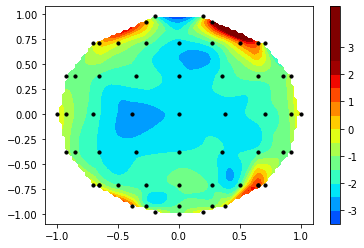

In [81]:
i=1
fig, ax = plt.subplots()
zi = griddata((x_pos, y_pos), mode_0[:,i], (xi[None,:], yi[:,None]), method='cubic')

cax = ax.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=vmin_mode, vmax=vmax_mode)
ax.scatter(x_pos,y_pos,marker='o',c='k',s=10)
#ax.set_title('Gaussian noise with vertical colorbar')
ax.set_xlim(min(x_pos)*1.1,max(x_pos)*1.1)
ax.set_ylim(min(y_pos)*1.1,max(y_pos)*1.1)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[-3,-2,-1, 0, 1,2,3,4])
cbar.ax.set_yticklabels(['-3','-2','-1', '0', '1','2','3','4'])  # vertically oriented colorbar

* Controle de la qualité de la décomposition

In [7]:
vp       = fPCA.getEigenValues()
Phi      = fPCA.getModes()
Xi       = np.array(fPCA.project(process_sample))
XiLambda = Xi * ot.Point([np.sqrt(x) for x in vp])
T        = np.array([t for t in spatiotemp_mesh])
V_app    = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) 

Résidu Max sur l'echantillon:      1.0869527500290133e-11
Ratio Valeur Propre 1/50:           0.0015677661521484448
Pourcentage de variance au mode 50: 0.9345339359537749


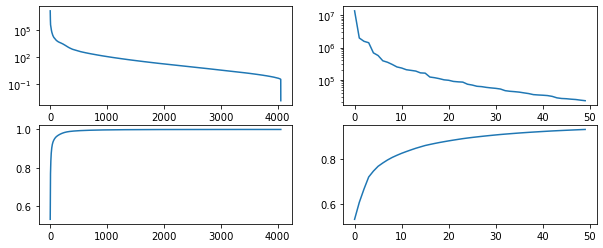

In [8]:
RandIdx = np.random.randint (0, process_sample.getSize()-1, 50 ).tolist()
Residu  = np.array ([V_app.getMarginal(k)(T) for k in RandIdx])
Residu -= np.array ([process_sample[k]for k in RandIdx])

pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(2,2, figsize=(10,4))

ax[0,0].semilogy(vp)  ; ax[0,1].semilogy(vp[0:50])
ax[1,0].plot    (pVar); ax[1,1].plot    (pVar[0:50])
print ('Résidu Max sur l\'echantillon:     ', np.max(Residu))
print ('Ratio Valeur Propre 1/50:          ', vp[50]/vp[0])
print ('Pourcentage de variance au mode 50:', pVar[49])

* Effet de la troncature

Mode Max   max erreur moy   max erreur max   valeur max      
    10         2.40e+00         6.46e+02         9.36e+02    
    20         9.97e-01         3.14e+02         9.36e+02    
    40         6.28e-01         2.86e+02         9.36e+02    
    80         5.18e-01         2.60e+02         9.36e+02    
   150         3.95e-01         1.80e+02         9.36e+02    
   300         2.22e-01         8.83e+01         9.36e+02    
   600         1.23e-01         6.40e+01         9.36e+02    
   1200        5.96e-02         2.64e+01         9.36e+02    
   2400        2.24e-02         7.09e+00         9.36e+02    
   3500        9.55e-03         1.23e+00         9.36e+02    
   3800        6.34e-03         8.16e-01         9.36e+02    
   4000        2.80e-03         3.74e-01         9.36e+02    
   4025        2.08e-03         2.71e-01         9.36e+02    
   4050        4.44e-04         5.96e-02         9.36e+02    
   4054        2.30e-04         2.77e-02         9.36e+02    
   4056 

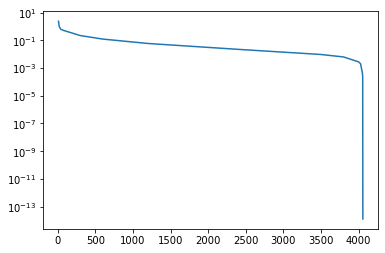

In [9]:
RandIdx = np.random.randint (0, process_sample.getSize()-1, 15 ).tolist()
modes   = fPCA.getModes()
Residus = []
Y       = np.array ([process_sample[k]for k in RandIdx])
rangeModes = [10, 20 , 40 , 80, 150, 300, 600, 1200, 2400, 3500, 3800, 4000, 4025, 4050, 4054,4056]
print ('{:10}'.format('Mode Max'),'{:16}'.format( 'max erreur moy'), '{:16}'.format( 'max erreur max'), '{:16}'.format( 'valeur max'))

for k in rangeModes:
    subXiLambda = XiLambda[:, 0:k ]
    subModes    = [modes[i] for i in range (k)]


    V_app       = ot.DualLinearCombinationFunction(subModes, np.array(subXiLambda).T)
    Residu      = np.array ([V_app.getMarginal(idx)(T) for idx in RandIdx])
    Residu     -= Y
    res         = np.max(np.linalg.norm(Residu, axis=1))
    resMax      = np.max (Residu)
    Residus.append(res/4056)
    print ('{:^10}'.format(k), '{:^16.2e}'.format(res/4056), '{:^16.2e}'.format(resMax), '{:^16.2e}'.format(np.max(Y)))
    
plt.semilogy (np.array (rangeModes),np.array (Residus))

In [13]:
len(modes)

4056

In [12]:
np.array(subXiLambda).T.shape

(4056, 4057)

* Analyse par cluster (Event / NoEvent)

In [10]:
XiEvent   = Xi[0:len(eventFiles)]
XiNoEvent = Xi[len(eventFiles):nSample-1]


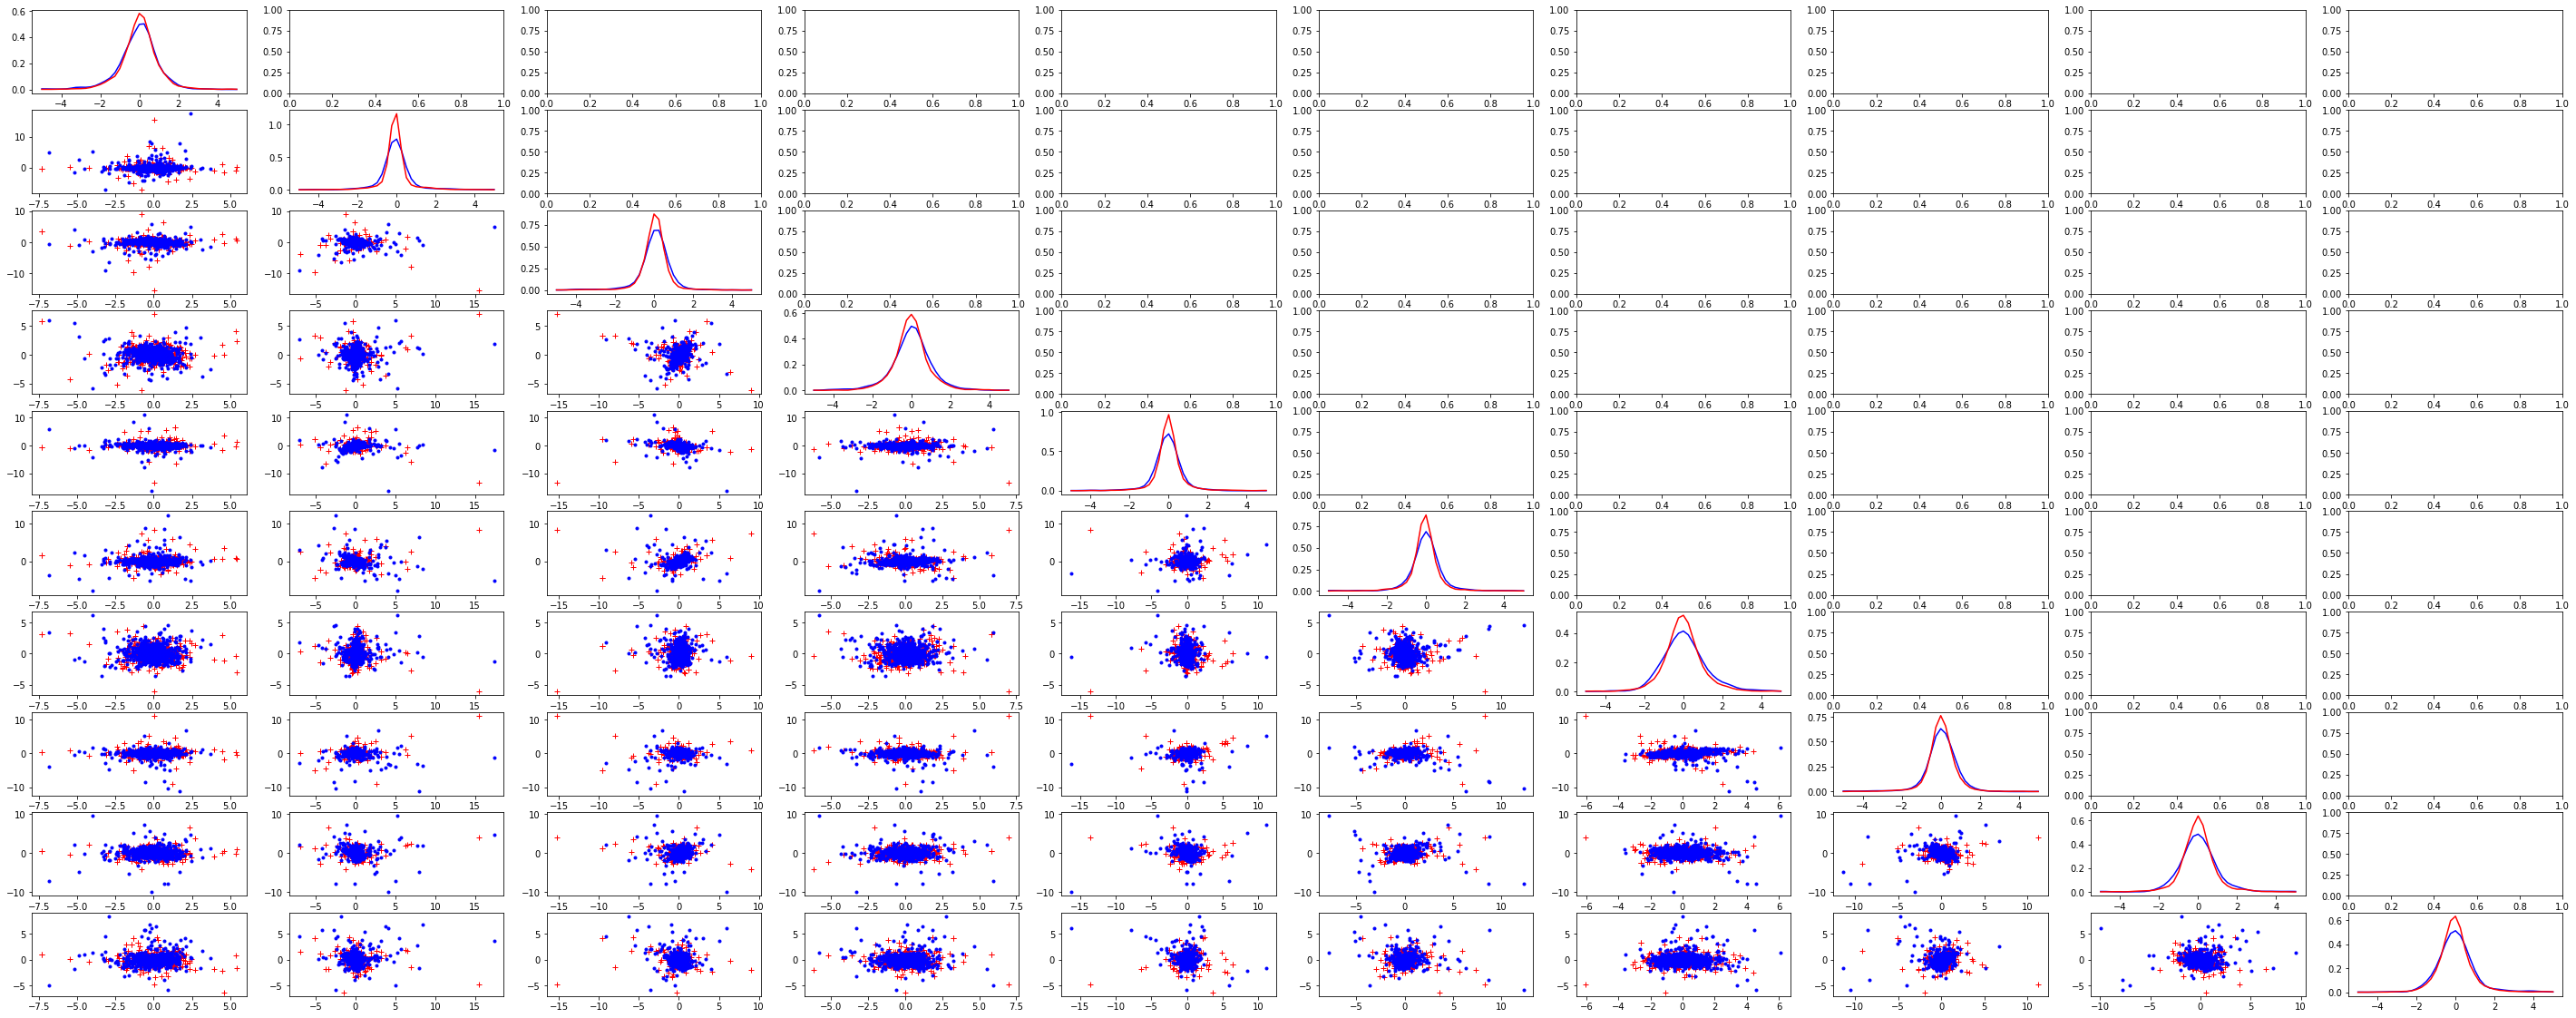

In [11]:
from scipy.stats.kde import gaussian_kde

minMode = 10
nbModes = 10

marginalEvent    = [gaussian_kde(XiEvent  [:,k]) for k in range (minMode, minMode+nbModes)]
marginalNoEvent  = [gaussian_kde(XiNoEvent[:,k]) for k in range (minMode, minMode+nbModes)]

fig, ax = plt.subplots(nbModes,nbModes, figsize=(50,20))
x       = np.linspace(-5, 5.0, 41)

for k in range (0, nbModes):
    ax[k,k].plot (x, [marginalEvent  [k](i) for i in x], "b")
    ax[k,k].plot (x, [marginalNoEvent[k](i) for i in x], "r")

RandIdx = np.random.randint (0, len(XiNoEvent)-1, len(XiEvent)).tolist()
XiNoEvt = np.array([XiNoEvent[k,:] for k in RandIdx])
for k in range (minMode,minMode+nbModes):
    ik = k - minMode
    for j in range (minMode, k):
        ij = j - minMode
        ax[ik,ij].plot (XiNoEvt[:,j], XiNoEvt[:,k],'r+')
        ax[ik,ij].plot (XiEvent[:,j], XiEvent[:,k],'b.')


In [12]:
from sklearn import svm
import random

In [13]:
Y=np.concatenate ([np.array(len(eventFiles)*[1]), np.array(len(noEventFiles)*[0])])

In [14]:
trainEvent   = random.sample (range(0              , len(eventFiles)), 400 )
trainNoEvent = random.sample (range(len(eventFiles), Y.shape[0]     ), 400 )

notInTrainE = np.array ([k for k in range (0              , len(eventFiles)) if k not in trainEvent  ])
notInTrainN = np.array ([k for k in range (len(eventFiles), Y.shape[0]     ) if k not in trainNoEvent])

train       = np.concatenate ([trainEvent, trainNoEvent])
test        = np.concatenate ([notInTrainE, notInTrainN[0:notInTrainE.shape[0]]])

Xitrain     = Xi [train]
Xitest      = Xi [test]
Ytrain      = Y  [train]
Ytest       = Y  [test]                               

In [15]:
clf = svm.SVC()

In [16]:
accuracy = []
for k in [1, 2, 5, 10, 50, 100, 200, 500, 1000]:
    clf.fit (Xitrain[:,0:k], Ytrain)
    Ypred = clf.predict(Xitest[0:2*notInTrainE.shape[0],0:k])
    Res = Ytest - Ypred
    accuracy.append(1. - np.mean(Res))

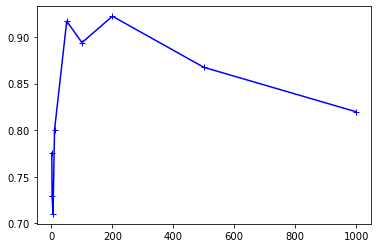

In [17]:
plt.plot ([1, 2, 5, 10, 50, 100, 200, 500, 1000], accuracy, 'b+-')